<a href="https://colab.research.google.com/github/NbtKmy/gc_workshops/blob/main/Netzwerk_collocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kollokation (Collocation)

## Beispiel mit Frankenstein

Textvorlage aus [Project Gutenberg](https://www.gutenberg.org/ebooks/41445).


In [9]:
!pip install -q nltk

Notwendige Pakages installieren. Man kann einfachhalber alle Pakages installieren, aber es verlangt ca. 3 GB...

In [ ]:
import nltk
nltk.download("punkt") # Worttrennung
nltk.download("averaged_perceptron_tagger") # Part of Speech erhalten
nltk.download("wordnet") # Lemmatisierung
nltk.download("stopwords") 

In [ ]:
from google.colab import files

uploaded = files.upload()
text_file = next(iter(uploaded))
data = ""
with open(text_file) as f:
    data = f.read()


## Text in Daten umwandeln

In diesem Schritt wird der Text zuerst in eine Array aus einzelnen Sätzen umgewandelt. Danach werden die Sätze tokenisiert. 
Daraus ergibt sich eine 2-dimensionale Array.

Z.B.:
```
[["Guten", "Tag", "!"],
["Mein", "Name", "ist", "XYZ", "."]]
```

Aus dieser Array werden Stopwörter entfernt. Danach werden POS-Tags den einzelnen Wörtern hinzugefügt.

In [ ]:
import nltk
from nltk import tokenize
from nltk import stem
from nltk.corpus import stopwords

stopset = list(set(stopwords.words("english")))
additionaly_stopwd = ["”", "’", "“", "*", "——"]
stopset += additionaly_stopwd
sentences_list = []
sentences_raw = nltk.sent_tokenize(data)
for sentence in sentences_raw: 
    words = nltk.word_tokenize(sentence)
    filtered_wds = []
    for wrds in words:
        if wrds not in stopset:
            filtered_wds.append(wrds)

    pos = nltk.pos_tag(filtered_wds)
    sentences_list.append(pos)

print(sentences_list)




## Tag für pos (Part of Speech)

Tags für POS sehen kriptisch aus... Deshalb hier die Tabelle!

| Tag | Meaning |
|-----|---------|
| CC | Coordinating conjunction	|
| CD | Cardinal number| 
| DT | Determiner |
| EX | Existential there |
| FW | Foreign word |
| IN | Preposition or subordinating conjunction |
| JJ | Adjective |
| JJR | Adjective, comparative |
| JJS	| Adjective, superlative |
| LS | List item marker |
| MD | Modal |
| NN | Noun, singular or mass |
| NNS | Noun, plural |
| NNP	| Proper noun, singular |
| NNPS | Proper noun, plural |
| PDT | Predeterminer	|
| POS | Possessive ending	|
| PRP | Personal pronoun |
| PRP\$ |Possessive pronoun |
| RB | Adverb |
| RBR | Adverb, comparative	| 
| RBS | Adverb, superlative	|
| RP | Particle	|
| SYM | Symbol |
| TO | to as preposition |
| UH | Interjection |
| VB |	Verb, base form	|
| VBD | Verb, past tense |
| VBG	| Verb, gerund or present participle |
| VBN |	Verb, past participle	|
| VBP	| Verb, non-3rd person singular present	| 
| VBZ |	Verb, 3rd person singular present	|
| WDT	| Wh-determiner	|
| WP | Wh-pronoun |
| WP\$ | Possessive wh-pronoun |
| WRB	| Wh-adverb	|

In [ ]:

# Liste der POS, die hier berücksichtigt werden sollen
pos_list = ["FW", "JJ", "JJR", "JJS", "NN", "NNS", "RB", "RBR", "RBS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
proper_nouns = ["NNP", "NNPS"]

lemmatizer = stem.WordNetLemmatizer()
sent_list = []
for sent in sentences_list:

    word_list = []
    for w in sent:
        if w[1] in pos_list:
            lem = lemmatizer.lemmatize(w[0].lower())
            word_list.append(lem)
        elif w[1] in proper_nouns:
            word_list.append(w[0])
        
    sent_list.append(word_list)


print(sent_list)


# Kollokation aufzählen und filtern

Die Wörterpaare sind hier zusammengezählt. Dann werden sie nach 2 Kriterien herausgefiltert:

1. Kriterium: Erscheinungshäufigkeit mehr als 4-mal im gesamten Text

1. Höherer Jaccard-Koeffizient

Jaccard-Koeffizient gilt als Indiz der Ahnlichkeit der zwei unterschiedlichen Wörter. Der Jaccard-Koeffizient wird wie folgt berechnet:

$$
J(A,B) = \frac{A \cap B}{A \cup B} = \frac {A \cap B}{A + B - {A \cap B}}
$$



In [73]:
from collections import Counter, OrderedDict
from itertools import combinations, dropwhile

jaccard_dist = []
threshold = 0.13
pair_all = []
min_count = 4

for s in sent_list:
    pair_temp = list(combinations(set(s), 2))

    for i, pair in enumerate(pair_temp):
        pair_temp[i] = tuple(sorted(pair))
    pair_all += pair_temp

pair_count = Counter(pair_all)
for key, count in dropwhile(lambda key_count: key_count[1] >= min_count, pair_count.most_common()):
    del pair_count[key]

word_count = Counter()
for s in sent_list:
    word_count += Counter(set(s))

for pair, count in pair_count.items():
    jaccard_dist.append(count / (word_count[pair[0]] + word_count[pair[1]] - count))


jaccard_dict = OrderedDict()
for (pair, count), coef in zip(pair_count.items(), jaccard_dist):
    if coef >= threshold:
        jaccard_dict[pair] = coef
        print(pair, count, coef, word_count[pair[0]], word_count[pair[1]], sep="\t")

('Did', 'thee')	6	0.3333333333333333	9	15
('SAVILLE', '_to')	4	0.8	4	5
('Mrs._', 'SAVILLE')	4	1.0	4	4
('SAVILLE', '_England_')	4	1.0	4	4
('Mrs._', '_to')	4	0.8	4	5
('_England_', '_to')	4	0.8	4	5
('Mrs._', '_England_')	4	1.0	4	4
('discovery', 'voyage')	5	0.14705882352941177	23	16
('branch', 'science')	6	0.16666666666666666	15	27
('country', 'native')	14	0.21212121212121213	52	28
('girl', 'young')	8	0.16	28	30
('man', 'old')	34	0.2328767123287671	130	50
('spring', 'winter')	4	0.16666666666666666	15	13
('ice', 'sea')	10	0.15625	38	36
('gigantic', 'stature')	5	0.5555555555555556	6	8
('dog', 'sledge')	4	0.25	7	13
('asked', 'question')	4	0.14285714285714285	15	17
('deeply', 'impressed')	4	0.18181818181818182	17	9
('natural', 'philosophy')	14	0.6086956521739131	22	15
('natural', 'science')	7	0.16666666666666666	22	27
('philosophy', 'science')	6	0.16666666666666666	15	27
('Agrippa', 'Cornelius')	6	0.75	8	6
('Victor', 'dear')	11	0.13924050632911392	27	63
('Albertus', 'Magnus')	4	1.0	4	4
('morni

## Visualisierung

Bei der Visualisierung wird [Graphviz](https://graphviz.org/) verwendet. In der Google-Colab-Umgebung kann das Software durch Ubuntu-Package installiert werden.

In [ ]:
!apt install graphviz graphviz-dev

Number of nodes =  115
Number of edges =  71


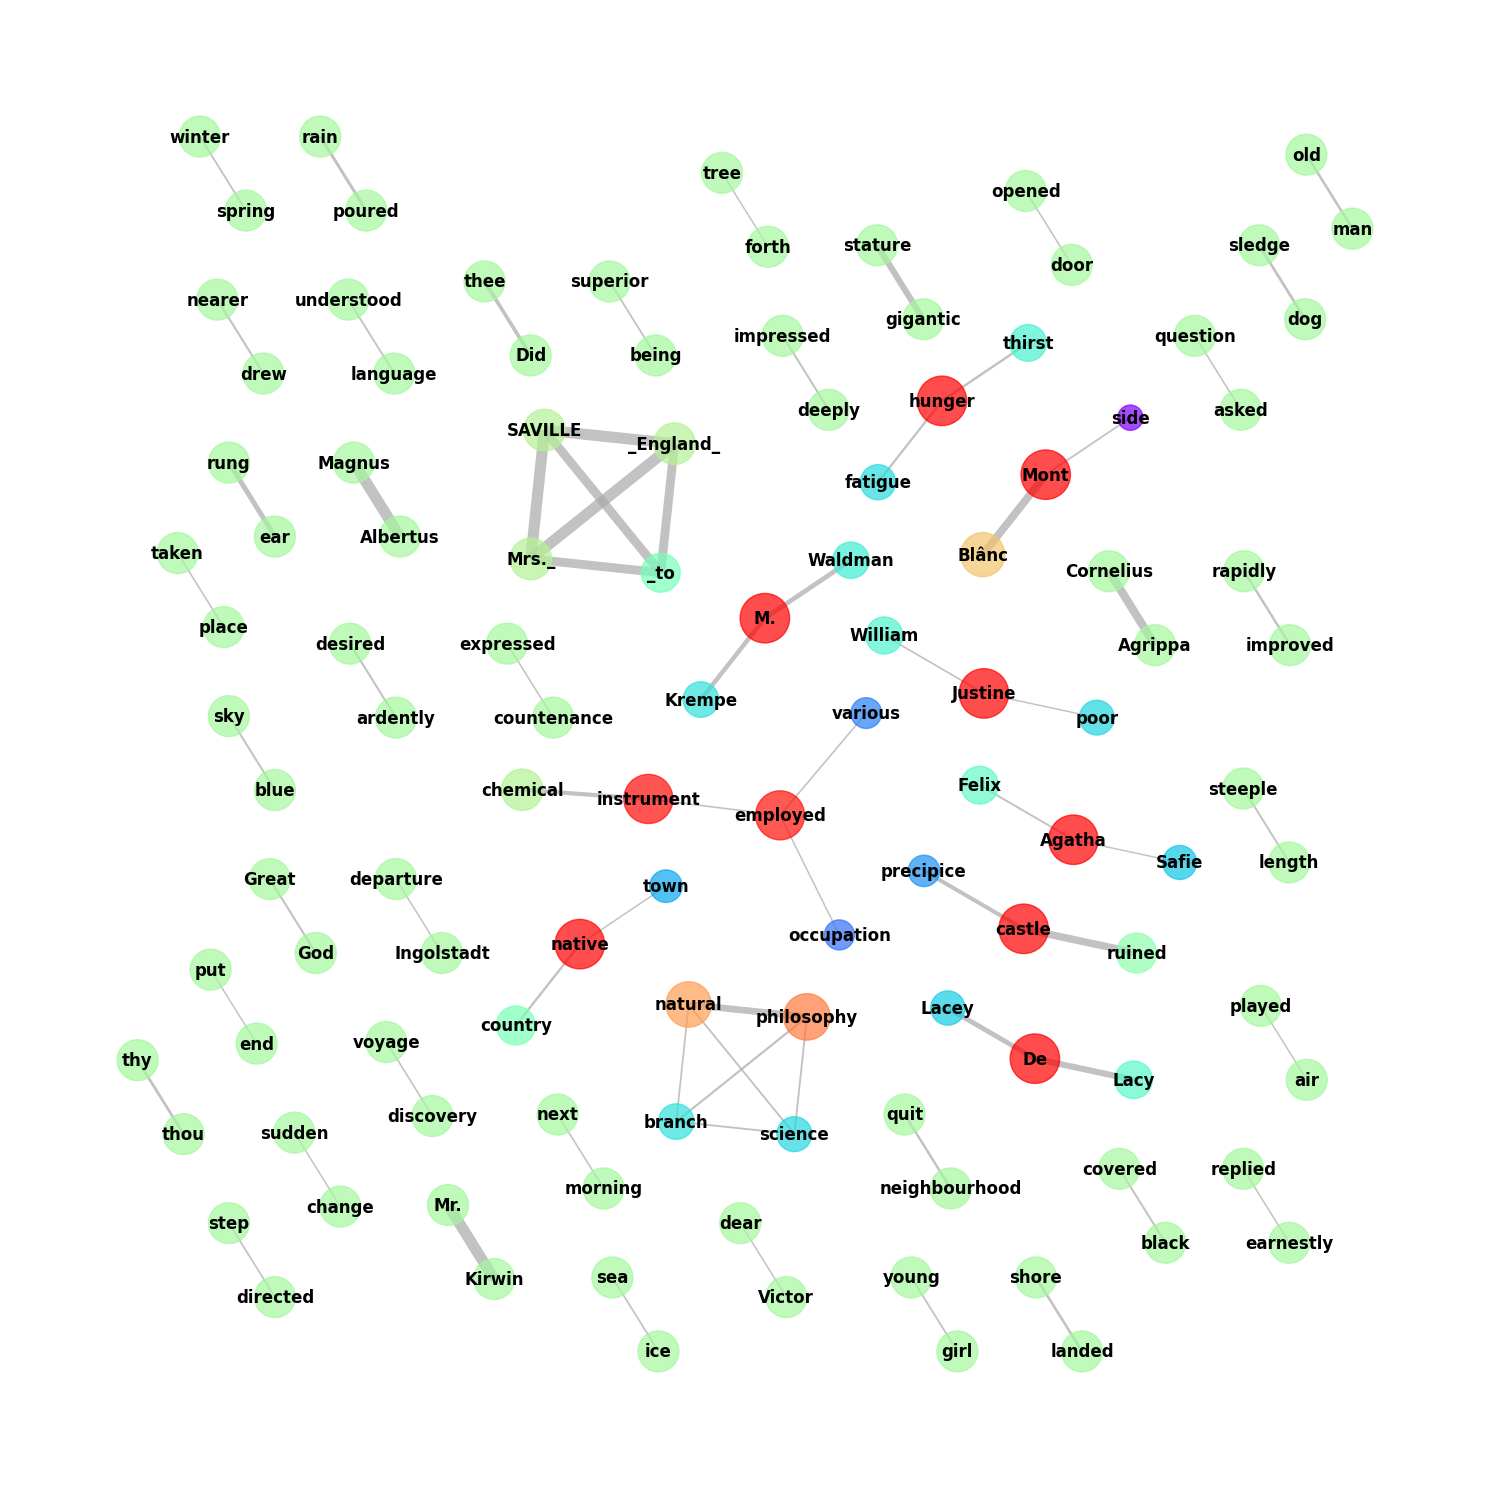

In [74]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.drawing import nx_agraph



G = nx.MultiGraph()
nodes = sorted(set([j for pair in jaccard_dict.keys() for j in pair]))
G.add_nodes_from(nodes)
print("Number of nodes = ", G.number_of_nodes())

for pair, coef in jaccard_dict.items():
    G.add_edge(pair[0], pair[1], weight=coef)
print("Number of edges = ", G.number_of_edges())

plt.figure(figsize=(15, 15))
seed = 0
np.random.seed(seed)
pos = nx_agraph.graphviz_layout(G, prog="neato", args="-Goverlap='scalexy' -Gsep='+6' -Gnodesep=0.8 -Gsplines='polyline' -GpackMode='graph' -Gstart={}".format(seed))

# Die Grösse der Nodes wird durch PageRank (Zentralität) bestimmt.
pr = nx.pagerank(G)
nx.draw_networkx_nodes(G, pos, node_color=list(pr.values()), cmap=plt.cm.rainbow, alpha=0.7, node_size=[100000*v for v in pr.values()])
nx.draw_networkx_labels(G, pos, font_weight="bold")

# Weight der Kanten sind Jaccard-Koeffizitent
edge_width = [d["weight"] * 8 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color="darkgrey", width=edge_width)
plt.axis("off")
plt.tight_layout()
plt.savefig("kollokation.png", bbox_inches="tight")